In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer
from uncertainty_testbed.uncertainty_models.hla_dropout import HLADropout, HLALinear

2022-06-22 16:10:38.038845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-22 16:10:38.038868: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.3)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        layers = (
            keras.Input(shape=(eg.num_inputs,), name="input"),
            keras.layers.Dense(60, activation="relu"),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(60, activation="relu"),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(60, activation="relu"),
            keras.layers.Dropout(0.25),
            HLALinear(samples=100, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros",
                      activation=tf.keras.activations.sigmoid, sigma_scaling=0.1, name="hla_linear")
        )
        model = HLADropout(
            layer_tuple=layers,
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=("accuracy", "AUC"),
            name="HLADropout"
        )

        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_hla_linear_loss"]
        val_auc = history_dict["val_hla_linear_auc"]
        val_accuracy = history_dict["val_hla_linear_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            #champion_params["model"] = keras.models.clone_model(model)
        del model
        gc;
        

#model = keras.models.clone_model(champion_params["model"])

2022-06-22 16:10:47.294421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-22 16:10:47.294456: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-22 16:10:47.294480: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-06-22 16:10:47.294777: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/119
130/130 [==============================] - 2s 5ms/step - loss: 0.7046 - hla_linear_loss: 0.7046 - hla_linear_accuracy: 0.5049 - hla_linear_auc: 0.5030 - val_loss: 0.6948 - val_hla_linear_loss: 0.6948 - val_hla_linear_accuracy: 0.5125 - val_hla_linear_auc: 0.5117
Epoch 2/119
130/130 [==============================] - 0s 4ms/step - loss: 0.7013 - hla_linear_loss: 0.7013 - hla_linear_accuracy: 0.5094 - hla_linear_auc: 0.5096 - val_loss: 0.6909 - val_hla_linear_loss: 0.6909 - val_hla_linear_accuracy: 0.5303 - val_hla_linear_auc: 0.5392
Epoch 3/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6975 - hla_linear_loss: 0.6975 - hla_linear_accuracy: 0.5160 - hla_linear_auc: 0.5226 - val_loss: 0.6873 - val_hla_linear_loss: 0.6873 - val_hla_linear_accuracy: 0.5469 - val_hla_linear_auc: 0.5661
Epoch 4/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6956 - hla_linear_loss: 0.6956 - hla_linear_accuracy: 0.5239 - hla_linear_auc: 0.5301 - val_loss: 

Epoch 31/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5861 - hla_linear_loss: 0.5861 - hla_linear_accuracy: 0.6980 - hla_linear_auc: 0.7665 - val_loss: 0.5322 - val_hla_linear_loss: 0.5322 - val_hla_linear_accuracy: 0.7781 - val_hla_linear_auc: 0.8460
Epoch 32/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5859 - hla_linear_loss: 0.5859 - hla_linear_accuracy: 0.6979 - hla_linear_auc: 0.7673 - val_loss: 0.5274 - val_hla_linear_loss: 0.5274 - val_hla_linear_accuracy: 0.7821 - val_hla_linear_auc: 0.8484
Epoch 33/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5806 - hla_linear_loss: 0.5806 - hla_linear_accuracy: 0.7048 - hla_linear_auc: 0.7729 - val_loss: 0.5226 - val_hla_linear_loss: 0.5226 - val_hla_linear_accuracy: 0.7858 - val_hla_linear_auc: 0.8507
Epoch 34/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5783 - hla_linear_loss: 0.5783 - hla_linear_accuracy: 0.7072 - hla_linear_auc: 0.7757 - val_lo

Epoch 61/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5316 - hla_linear_loss: 0.5316 - hla_linear_accuracy: 0.7573 - hla_linear_auc: 0.8239 - val_loss: 0.4692 - val_hla_linear_loss: 0.4692 - val_hla_linear_accuracy: 0.8259 - val_hla_linear_auc: 0.8746
Epoch 62/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5312 - hla_linear_loss: 0.5312 - hla_linear_accuracy: 0.7585 - hla_linear_auc: 0.8250 - val_loss: 0.4684 - val_hla_linear_loss: 0.4684 - val_hla_linear_accuracy: 0.8268 - val_hla_linear_auc: 0.8749
Epoch 63/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5281 - hla_linear_loss: 0.5281 - hla_linear_accuracy: 0.7615 - hla_linear_auc: 0.8281 - val_loss: 0.4675 - val_hla_linear_loss: 0.4675 - val_hla_linear_accuracy: 0.8274 - val_hla_linear_auc: 0.8752
Epoch 64/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5278 - hla_linear_loss: 0.5278 - hla_linear_accuracy: 0.7608 - hla_linear_auc: 0.8274 - val_lo

Epoch 91/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5063 - hla_linear_loss: 0.5063 - hla_linear_accuracy: 0.7821 - hla_linear_auc: 0.8450 - val_loss: 0.4492 - val_hla_linear_loss: 0.4492 - val_hla_linear_accuracy: 0.8357 - val_hla_linear_auc: 0.8829
Epoch 92/119
130/130 [==============================] - 1s 4ms/step - loss: 0.5050 - hla_linear_loss: 0.5050 - hla_linear_accuracy: 0.7836 - hla_linear_auc: 0.8463 - val_loss: 0.4486 - val_hla_linear_loss: 0.4486 - val_hla_linear_accuracy: 0.8364 - val_hla_linear_auc: 0.8831
Epoch 93/119
130/130 [==============================] - 0s 4ms/step - loss: 0.5024 - hla_linear_loss: 0.5024 - hla_linear_accuracy: 0.7824 - hla_linear_auc: 0.8475 - val_loss: 0.4480 - val_hla_linear_loss: 0.4480 - val_hla_linear_accuracy: 0.8367 - val_hla_linear_auc: 0.8834
Epoch 94/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5015 - hla_linear_loss: 0.5015 - hla_linear_accuracy: 0.7864 - hla_linear_auc: 0.8487 - val_lo

Epoch 1/119
130/130 [==============================] - 2s 5ms/step - loss: 0.7005 - hla_linear_loss: 0.7005 - hla_linear_accuracy: 0.5062 - hla_linear_auc: 0.5118 - val_loss: 0.6839 - val_hla_linear_loss: 0.6839 - val_hla_linear_accuracy: 0.5749 - val_hla_linear_auc: 0.6004
Epoch 2/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6904 - hla_linear_loss: 0.6904 - hla_linear_accuracy: 0.5328 - hla_linear_auc: 0.5478 - val_loss: 0.6769 - val_hla_linear_loss: 0.6769 - val_hla_linear_accuracy: 0.6048 - val_hla_linear_auc: 0.6497
Epoch 3/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6852 - hla_linear_loss: 0.6852 - hla_linear_accuracy: 0.5461 - hla_linear_auc: 0.5687 - val_loss: 0.6703 - val_hla_linear_loss: 0.6703 - val_hla_linear_accuracy: 0.6293 - val_hla_linear_auc: 0.6841
Epoch 4/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6802 - hla_linear_loss: 0.6802 - hla_linear_accuracy: 0.5613 - hla_linear_auc: 0.5897 - val_loss: 

Epoch 31/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5546 - hla_linear_loss: 0.5546 - hla_linear_accuracy: 0.7302 - hla_linear_auc: 0.8000 - val_loss: 0.4902 - val_hla_linear_loss: 0.4902 - val_hla_linear_accuracy: 0.8072 - val_hla_linear_auc: 0.8659
Epoch 32/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5571 - hla_linear_loss: 0.5571 - hla_linear_accuracy: 0.7303 - hla_linear_auc: 0.7992 - val_loss: 0.4881 - val_hla_linear_loss: 0.4881 - val_hla_linear_accuracy: 0.8080 - val_hla_linear_auc: 0.8668
Epoch 33/119
130/130 [==============================] - 0s 4ms/step - loss: 0.5491 - hla_linear_loss: 0.5491 - hla_linear_accuracy: 0.7375 - hla_linear_auc: 0.8074 - val_loss: 0.4861 - val_hla_linear_loss: 0.4861 - val_hla_linear_accuracy: 0.8105 - val_hla_linear_auc: 0.8675
Epoch 34/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5484 - hla_linear_loss: 0.5484 - hla_linear_accuracy: 0.7364 - hla_linear_auc: 0.8070 - val_lo

Epoch 61/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5154 - hla_linear_loss: 0.5154 - hla_linear_accuracy: 0.7732 - hla_linear_auc: 0.8385 - val_loss: 0.4550 - val_hla_linear_loss: 0.4550 - val_hla_linear_accuracy: 0.8326 - val_hla_linear_auc: 0.8798
Epoch 62/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5148 - hla_linear_loss: 0.5148 - hla_linear_accuracy: 0.7753 - hla_linear_auc: 0.8389 - val_loss: 0.4543 - val_hla_linear_loss: 0.4543 - val_hla_linear_accuracy: 0.8332 - val_hla_linear_auc: 0.8801
Epoch 63/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5121 - hla_linear_loss: 0.5121 - hla_linear_accuracy: 0.7758 - hla_linear_auc: 0.8411 - val_loss: 0.4535 - val_hla_linear_loss: 0.4535 - val_hla_linear_accuracy: 0.8334 - val_hla_linear_auc: 0.8804
Epoch 64/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5135 - hla_linear_loss: 0.5135 - hla_linear_accuracy: 0.7785 - hla_linear_auc: 0.8405 - val_lo

Epoch 91/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4897 - hla_linear_loss: 0.4897 - hla_linear_accuracy: 0.7944 - hla_linear_auc: 0.8565 - val_loss: 0.4327 - val_hla_linear_loss: 0.4327 - val_hla_linear_accuracy: 0.8405 - val_hla_linear_auc: 0.8889
Epoch 92/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4864 - hla_linear_loss: 0.4864 - hla_linear_accuracy: 0.7954 - hla_linear_auc: 0.8585 - val_loss: 0.4320 - val_hla_linear_loss: 0.4320 - val_hla_linear_accuracy: 0.8409 - val_hla_linear_auc: 0.8893
Epoch 93/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4814 - hla_linear_loss: 0.4814 - hla_linear_accuracy: 0.7967 - hla_linear_auc: 0.8608 - val_loss: 0.4311 - val_hla_linear_loss: 0.4311 - val_hla_linear_accuracy: 0.8412 - val_hla_linear_auc: 0.8895
Epoch 94/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4827 - hla_linear_loss: 0.4827 - hla_linear_accuracy: 0.7961 - hla_linear_auc: 0.8594 - val_lo

Epoch 1/119
130/130 [==============================] - 2s 8ms/step - loss: 0.6976 - hla_linear_loss: 0.6976 - hla_linear_accuracy: 0.5201 - hla_linear_auc: 0.5258 - val_loss: 0.6824 - val_hla_linear_loss: 0.6824 - val_hla_linear_accuracy: 0.5732 - val_hla_linear_auc: 0.6063
Epoch 2/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6888 - hla_linear_loss: 0.6888 - hla_linear_accuracy: 0.5401 - hla_linear_auc: 0.5574 - val_loss: 0.6753 - val_hla_linear_loss: 0.6753 - val_hla_linear_accuracy: 0.6040 - val_hla_linear_auc: 0.6521
Epoch 3/119
130/130 [==============================] - 1s 6ms/step - loss: 0.6838 - hla_linear_loss: 0.6838 - hla_linear_accuracy: 0.5535 - hla_linear_auc: 0.5755 - val_loss: 0.6685 - val_hla_linear_loss: 0.6685 - val_hla_linear_accuracy: 0.6280 - val_hla_linear_auc: 0.6830
Epoch 4/119
130/130 [==============================] - 1s 4ms/step - loss: 0.6782 - hla_linear_loss: 0.6782 - hla_linear_accuracy: 0.5651 - hla_linear_auc: 0.5959 - val_loss: 

Epoch 31/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5483 - hla_linear_loss: 0.5483 - hla_linear_accuracy: 0.7392 - hla_linear_auc: 0.8067 - val_loss: 0.4815 - val_hla_linear_loss: 0.4815 - val_hla_linear_accuracy: 0.8188 - val_hla_linear_auc: 0.8700
Epoch 32/119
130/130 [==============================] - 0s 4ms/step - loss: 0.5442 - hla_linear_loss: 0.5442 - hla_linear_accuracy: 0.7426 - hla_linear_auc: 0.8113 - val_loss: 0.4797 - val_hla_linear_loss: 0.4797 - val_hla_linear_accuracy: 0.8196 - val_hla_linear_auc: 0.8707
Epoch 33/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5427 - hla_linear_loss: 0.5427 - hla_linear_accuracy: 0.7453 - hla_linear_auc: 0.8127 - val_loss: 0.4780 - val_hla_linear_loss: 0.4780 - val_hla_linear_accuracy: 0.8204 - val_hla_linear_auc: 0.8713
Epoch 34/119
130/130 [==============================] - 1s 4ms/step - loss: 0.5419 - hla_linear_loss: 0.5419 - hla_linear_accuracy: 0.7442 - hla_linear_auc: 0.8127 - val_lo

Epoch 61/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5111 - hla_linear_loss: 0.5111 - hla_linear_accuracy: 0.7770 - hla_linear_auc: 0.8401 - val_loss: 0.4500 - val_hla_linear_loss: 0.4500 - val_hla_linear_accuracy: 0.8367 - val_hla_linear_auc: 0.8827
Epoch 62/119
130/130 [==============================] - 0s 4ms/step - loss: 0.5097 - hla_linear_loss: 0.5097 - hla_linear_accuracy: 0.7784 - hla_linear_auc: 0.8414 - val_loss: 0.4492 - val_hla_linear_loss: 0.4492 - val_hla_linear_accuracy: 0.8372 - val_hla_linear_auc: 0.8831
Epoch 63/119
130/130 [==============================] - 0s 4ms/step - loss: 0.5050 - hla_linear_loss: 0.5050 - hla_linear_accuracy: 0.7796 - hla_linear_auc: 0.8444 - val_loss: 0.4482 - val_hla_linear_loss: 0.4482 - val_hla_linear_accuracy: 0.8374 - val_hla_linear_auc: 0.8835
Epoch 64/119
130/130 [==============================] - 0s 4ms/step - loss: 0.5036 - hla_linear_loss: 0.5036 - hla_linear_accuracy: 0.7810 - hla_linear_auc: 0.8459 - val_lo

Epoch 91/119
130/130 [==============================] - 1s 4ms/step - loss: 0.4765 - hla_linear_loss: 0.4765 - hla_linear_accuracy: 0.7968 - hla_linear_auc: 0.8633 - val_loss: 0.4227 - val_hla_linear_loss: 0.4227 - val_hla_linear_accuracy: 0.8453 - val_hla_linear_auc: 0.8958
Epoch 92/119
130/130 [==============================] - 0s 4ms/step - loss: 0.4765 - hla_linear_loss: 0.4765 - hla_linear_accuracy: 0.7973 - hla_linear_auc: 0.8616 - val_loss: 0.4218 - val_hla_linear_loss: 0.4218 - val_hla_linear_accuracy: 0.8450 - val_hla_linear_auc: 0.8963
Epoch 93/119
130/130 [==============================] - 0s 4ms/step - loss: 0.4780 - hla_linear_loss: 0.4780 - hla_linear_accuracy: 0.7966 - hla_linear_auc: 0.8617 - val_loss: 0.4210 - val_hla_linear_loss: 0.4210 - val_hla_linear_accuracy: 0.8457 - val_hla_linear_auc: 0.8967
Epoch 94/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4722 - hla_linear_loss: 0.4722 - hla_linear_accuracy: 0.7995 - hla_linear_auc: 0.8657 - val_lo

Epoch 1/249
130/130 [==============================] - 1s 5ms/step - loss: 0.7085 - hla_linear_loss: 0.7085 - hla_linear_accuracy: 0.5027 - hla_linear_auc: 0.4972 - val_loss: 0.6987 - val_hla_linear_loss: 0.6987 - val_hla_linear_accuracy: 0.5073 - val_hla_linear_auc: 0.5014
Epoch 2/249
130/130 [==============================] - 0s 3ms/step - loss: 0.7046 - hla_linear_loss: 0.7046 - hla_linear_accuracy: 0.4989 - hla_linear_auc: 0.4962 - val_loss: 0.6968 - val_hla_linear_loss: 0.6968 - val_hla_linear_accuracy: 0.5065 - val_hla_linear_auc: 0.5049
Epoch 3/249
130/130 [==============================] - 0s 3ms/step - loss: 0.7020 - hla_linear_loss: 0.7020 - hla_linear_accuracy: 0.5002 - hla_linear_auc: 0.5007 - val_loss: 0.6958 - val_hla_linear_loss: 0.6958 - val_hla_linear_accuracy: 0.5063 - val_hla_linear_auc: 0.5090
Epoch 4/249
130/130 [==============================] - 0s 4ms/step - loss: 0.7006 - hla_linear_loss: 0.7006 - hla_linear_accuracy: 0.5061 - hla_linear_auc: 0.5073 - val_loss: 

Epoch 31/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6867 - hla_linear_loss: 0.6867 - hla_linear_accuracy: 0.5397 - hla_linear_auc: 0.5601 - val_loss: 0.6780 - val_hla_linear_loss: 0.6780 - val_hla_linear_accuracy: 0.5839 - val_hla_linear_auc: 0.6233
Epoch 32/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6865 - hla_linear_loss: 0.6865 - hla_linear_accuracy: 0.5395 - hla_linear_auc: 0.5580 - val_loss: 0.6773 - val_hla_linear_loss: 0.6773 - val_hla_linear_accuracy: 0.5859 - val_hla_linear_auc: 0.6266
Epoch 33/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6852 - hla_linear_loss: 0.6852 - hla_linear_accuracy: 0.5447 - hla_linear_auc: 0.5646 - val_loss: 0.6766 - val_hla_linear_loss: 0.6766 - val_hla_linear_accuracy: 0.5884 - val_hla_linear_auc: 0.6303
Epoch 34/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6845 - hla_linear_loss: 0.6845 - hla_linear_accuracy: 0.5419 - hla_linear_auc: 0.5664 - val_lo

Epoch 61/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6634 - hla_linear_loss: 0.6634 - hla_linear_accuracy: 0.5991 - hla_linear_auc: 0.6399 - val_loss: 0.6438 - val_hla_linear_loss: 0.6438 - val_hla_linear_accuracy: 0.6736 - val_hla_linear_auc: 0.7324
Epoch 62/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6628 - hla_linear_loss: 0.6628 - hla_linear_accuracy: 0.6016 - hla_linear_auc: 0.6403 - val_loss: 0.6420 - val_hla_linear_loss: 0.6420 - val_hla_linear_accuracy: 0.6763 - val_hla_linear_auc: 0.7362
Epoch 63/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6609 - hla_linear_loss: 0.6609 - hla_linear_accuracy: 0.6048 - hla_linear_auc: 0.6467 - val_loss: 0.6401 - val_hla_linear_loss: 0.6401 - val_hla_linear_accuracy: 0.6787 - val_hla_linear_auc: 0.7399
Epoch 64/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6586 - hla_linear_loss: 0.6586 - hla_linear_accuracy: 0.6116 - hla_linear_auc: 0.6528 - val_lo

Epoch 91/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6138 - hla_linear_loss: 0.6138 - hla_linear_accuracy: 0.6713 - hla_linear_auc: 0.7315 - val_loss: 0.5671 - val_hla_linear_loss: 0.5671 - val_hla_linear_accuracy: 0.7405 - val_hla_linear_auc: 0.8182
Epoch 92/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6106 - hla_linear_loss: 0.6106 - hla_linear_accuracy: 0.6762 - hla_linear_auc: 0.7364 - val_loss: 0.5640 - val_hla_linear_loss: 0.5640 - val_hla_linear_accuracy: 0.7419 - val_hla_linear_auc: 0.8204
Epoch 93/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6109 - hla_linear_loss: 0.6109 - hla_linear_accuracy: 0.6733 - hla_linear_auc: 0.7346 - val_loss: 0.5612 - val_hla_linear_loss: 0.5612 - val_hla_linear_accuracy: 0.7441 - val_hla_linear_auc: 0.8225
Epoch 94/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6095 - hla_linear_loss: 0.6095 - hla_linear_accuracy: 0.6763 - hla_linear_auc: 0.7361 - val_lo

Epoch 121/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5571 - hla_linear_loss: 0.5571 - hla_linear_accuracy: 0.7286 - hla_linear_auc: 0.7984 - val_loss: 0.4904 - val_hla_linear_loss: 0.4904 - val_hla_linear_accuracy: 0.8041 - val_hla_linear_auc: 0.8665
Epoch 122/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5558 - hla_linear_loss: 0.5558 - hla_linear_accuracy: 0.7319 - hla_linear_auc: 0.8009 - val_loss: 0.4887 - val_hla_linear_loss: 0.4887 - val_hla_linear_accuracy: 0.8052 - val_hla_linear_auc: 0.8674
Epoch 123/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5528 - hla_linear_loss: 0.5528 - hla_linear_accuracy: 0.7290 - hla_linear_auc: 0.8034 - val_loss: 0.4868 - val_hla_linear_loss: 0.4868 - val_hla_linear_accuracy: 0.8076 - val_hla_linear_auc: 0.8683
Epoch 124/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5534 - hla_linear_loss: 0.5534 - hla_linear_accuracy: 0.7364 - hla_linear_auc: 0.8039 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.5252 - hla_linear_loss: 0.5252 - hla_linear_accuracy: 0.7619 - hla_linear_auc: 0.8298 - val_loss: 0.4596 - val_hla_linear_loss: 0.4596 - val_hla_linear_accuracy: 0.8333 - val_hla_linear_auc: 0.8790
Epoch 151/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5265 - hla_linear_loss: 0.5265 - hla_linear_accuracy: 0.7638 - hla_linear_auc: 0.8294 - val_loss: 0.4590 - val_hla_linear_loss: 0.4590 - val_hla_linear_accuracy: 0.8339 - val_hla_linear_auc: 0.8792
Epoch 152/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5226 - hla_linear_loss: 0.5226 - hla_linear_accuracy: 0.7670 - hla_linear_auc: 0.8325 - val_loss: 0.4584 - val_hla_linear_loss: 0.4584 - val_hla_linear_accuracy: 0.8341 - val_hla_linear_auc: 0.8795
Epoch 153/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5247 - hla_linear_loss: 0.5247 - hla_linear_accuracy: 0.7675 - hla_linear_auc: 0.8316 - val_loss: 0.4579

Epoch 180/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5055 - hla_linear_loss: 0.5055 - hla_linear_accuracy: 0.7833 - hla_linear_auc: 0.8448 - val_loss: 0.4447 - val_hla_linear_loss: 0.4447 - val_hla_linear_accuracy: 0.8419 - val_hla_linear_auc: 0.8838
Epoch 181/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5080 - hla_linear_loss: 0.5080 - hla_linear_accuracy: 0.7811 - hla_linear_auc: 0.8429 - val_loss: 0.4445 - val_hla_linear_loss: 0.4445 - val_hla_linear_accuracy: 0.8418 - val_hla_linear_auc: 0.8840
Epoch 182/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5021 - hla_linear_loss: 0.5021 - hla_linear_accuracy: 0.7838 - hla_linear_auc: 0.8472 - val_loss: 0.4439 - val_hla_linear_loss: 0.4439 - val_hla_linear_accuracy: 0.8427 - val_hla_linear_auc: 0.8841
Epoch 183/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5080 - hla_linear_loss: 0.5080 - hla_linear_accuracy: 0.7822 - hla_linear_auc: 0.8426 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.4911 - hla_linear_loss: 0.4911 - hla_linear_accuracy: 0.7941 - hla_linear_auc: 0.8545 - val_loss: 0.4325 - val_hla_linear_loss: 0.4325 - val_hla_linear_accuracy: 0.8454 - val_hla_linear_auc: 0.8883
Epoch 210/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4913 - hla_linear_loss: 0.4913 - hla_linear_accuracy: 0.7932 - hla_linear_auc: 0.8544 - val_loss: 0.4322 - val_hla_linear_loss: 0.4322 - val_hla_linear_accuracy: 0.8457 - val_hla_linear_auc: 0.8884
Epoch 211/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4900 - hla_linear_loss: 0.4900 - hla_linear_accuracy: 0.7952 - hla_linear_auc: 0.8549 - val_loss: 0.4318 - val_hla_linear_loss: 0.4318 - val_hla_linear_accuracy: 0.8463 - val_hla_linear_auc: 0.8886
Epoch 212/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4864 - hla_linear_loss: 0.4864 - hla_linear_accuracy: 0.7970 - hla_linear_auc: 0.8569 - val_loss: 0.4314

Epoch 239/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4737 - hla_linear_loss: 0.4737 - hla_linear_accuracy: 0.8045 - hla_linear_auc: 0.8645 - val_loss: 0.4198 - val_hla_linear_loss: 0.4198 - val_hla_linear_accuracy: 0.8492 - val_hla_linear_auc: 0.8937
Epoch 240/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4780 - hla_linear_loss: 0.4780 - hla_linear_accuracy: 0.7988 - hla_linear_auc: 0.8611 - val_loss: 0.4195 - val_hla_linear_loss: 0.4195 - val_hla_linear_accuracy: 0.8493 - val_hla_linear_auc: 0.8939
Epoch 241/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4716 - hla_linear_loss: 0.4716 - hla_linear_accuracy: 0.8039 - hla_linear_auc: 0.8656 - val_loss: 0.4190 - val_hla_linear_loss: 0.4190 - val_hla_linear_accuracy: 0.8492 - val_hla_linear_auc: 0.8940
Epoch 242/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4737 - hla_linear_loss: 0.4737 - hla_linear_accuracy: 0.8025 - hla_linear_auc: 0.8644 - va

Epoch 19/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6894 - hla_linear_loss: 0.6894 - hla_linear_accuracy: 0.5326 - hla_linear_auc: 0.5495 - val_loss: 0.6816 - val_hla_linear_loss: 0.6816 - val_hla_linear_accuracy: 0.5809 - val_hla_linear_auc: 0.6184
Epoch 20/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6882 - hla_linear_loss: 0.6882 - hla_linear_accuracy: 0.5344 - hla_linear_auc: 0.5533 - val_loss: 0.6809 - val_hla_linear_loss: 0.6809 - val_hla_linear_accuracy: 0.5858 - val_hla_linear_auc: 0.6235
Epoch 21/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6884 - hla_linear_loss: 0.6884 - hla_linear_accuracy: 0.5356 - hla_linear_auc: 0.5524 - val_loss: 0.6802 - val_hla_linear_loss: 0.6802 - val_hla_linear_accuracy: 0.5897 - val_hla_linear_auc: 0.6291
Epoch 22/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6869 - hla_linear_loss: 0.6869 - hla_linear_accuracy: 0.5394 - hla_linear_auc: 0.5596 - val_lo

Epoch 49/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6570 - hla_linear_loss: 0.6570 - hla_linear_accuracy: 0.6095 - hla_linear_auc: 0.6554 - val_loss: 0.6309 - val_hla_linear_loss: 0.6309 - val_hla_linear_accuracy: 0.7033 - val_hla_linear_auc: 0.7726
Epoch 50/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6555 - hla_linear_loss: 0.6555 - hla_linear_accuracy: 0.6090 - hla_linear_auc: 0.6576 - val_loss: 0.6276 - val_hla_linear_loss: 0.6276 - val_hla_linear_accuracy: 0.7082 - val_hla_linear_auc: 0.7780
Epoch 51/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6515 - hla_linear_loss: 0.6515 - hla_linear_accuracy: 0.6194 - hla_linear_auc: 0.6676 - val_loss: 0.6238 - val_hla_linear_loss: 0.6238 - val_hla_linear_accuracy: 0.7137 - val_hla_linear_auc: 0.7831
Epoch 52/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6508 - hla_linear_loss: 0.6508 - hla_linear_accuracy: 0.6176 - hla_linear_auc: 0.6665 - val_lo

Epoch 79/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5761 - hla_linear_loss: 0.5761 - hla_linear_accuracy: 0.7090 - hla_linear_auc: 0.7768 - val_loss: 0.5042 - val_hla_linear_loss: 0.5042 - val_hla_linear_accuracy: 0.8102 - val_hla_linear_auc: 0.8653
Epoch 80/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5741 - hla_linear_loss: 0.5741 - hla_linear_accuracy: 0.7127 - hla_linear_auc: 0.7793 - val_loss: 0.5017 - val_hla_linear_loss: 0.5017 - val_hla_linear_accuracy: 0.8118 - val_hla_linear_auc: 0.8661
Epoch 81/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5742 - hla_linear_loss: 0.5742 - hla_linear_accuracy: 0.7124 - hla_linear_auc: 0.7796 - val_loss: 0.4994 - val_hla_linear_loss: 0.4994 - val_hla_linear_accuracy: 0.8134 - val_hla_linear_auc: 0.8669
Epoch 82/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5666 - hla_linear_loss: 0.5666 - hla_linear_accuracy: 0.7205 - hla_linear_auc: 0.7875 - val_lo

Epoch 109/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5398 - hla_linear_loss: 0.5398 - hla_linear_accuracy: 0.7545 - hla_linear_auc: 0.8178 - val_loss: 0.4649 - val_hla_linear_loss: 0.4649 - val_hla_linear_accuracy: 0.8328 - val_hla_linear_auc: 0.8773
Epoch 110/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5355 - hla_linear_loss: 0.5355 - hla_linear_accuracy: 0.7542 - hla_linear_auc: 0.8200 - val_loss: 0.4641 - val_hla_linear_loss: 0.4641 - val_hla_linear_accuracy: 0.8327 - val_hla_linear_auc: 0.8775
Epoch 111/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5328 - hla_linear_loss: 0.5328 - hla_linear_accuracy: 0.7590 - hla_linear_auc: 0.8228 - val_loss: 0.4632 - val_hla_linear_loss: 0.4632 - val_hla_linear_accuracy: 0.8328 - val_hla_linear_auc: 0.8777
Epoch 112/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5296 - hla_linear_loss: 0.5296 - hla_linear_accuracy: 0.7584 - hla_linear_auc: 0.8251 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.5114 - hla_linear_loss: 0.5114 - hla_linear_accuracy: 0.7773 - hla_linear_auc: 0.8400 - val_loss: 0.4470 - val_hla_linear_loss: 0.4470 - val_hla_linear_accuracy: 0.8415 - val_hla_linear_auc: 0.8827
Epoch 139/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5103 - hla_linear_loss: 0.5103 - hla_linear_accuracy: 0.7815 - hla_linear_auc: 0.8420 - val_loss: 0.4465 - val_hla_linear_loss: 0.4465 - val_hla_linear_accuracy: 0.8414 - val_hla_linear_auc: 0.8829
Epoch 140/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5142 - hla_linear_loss: 0.5142 - hla_linear_accuracy: 0.7772 - hla_linear_auc: 0.8382 - val_loss: 0.4461 - val_hla_linear_loss: 0.4461 - val_hla_linear_accuracy: 0.8417 - val_hla_linear_auc: 0.8831
Epoch 141/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5077 - hla_linear_loss: 0.5077 - hla_linear_accuracy: 0.7798 - hla_linear_auc: 0.8427 - val_loss: 0.4455

Epoch 168/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4933 - hla_linear_loss: 0.4933 - hla_linear_accuracy: 0.7918 - hla_linear_auc: 0.8522 - val_loss: 0.4312 - val_hla_linear_loss: 0.4312 - val_hla_linear_accuracy: 0.8465 - val_hla_linear_auc: 0.8889
Epoch 169/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4956 - hla_linear_loss: 0.4956 - hla_linear_accuracy: 0.7910 - hla_linear_auc: 0.8510 - val_loss: 0.4307 - val_hla_linear_loss: 0.4307 - val_hla_linear_accuracy: 0.8465 - val_hla_linear_auc: 0.8891
Epoch 170/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4863 - hla_linear_loss: 0.4863 - hla_linear_accuracy: 0.7950 - hla_linear_auc: 0.8569 - val_loss: 0.4300 - val_hla_linear_loss: 0.4300 - val_hla_linear_accuracy: 0.8464 - val_hla_linear_auc: 0.8893
Epoch 171/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4905 - hla_linear_loss: 0.4905 - hla_linear_accuracy: 0.7927 - hla_linear_auc: 0.8535 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.4761 - hla_linear_loss: 0.4761 - hla_linear_accuracy: 0.7995 - hla_linear_auc: 0.8625 - val_loss: 0.4163 - val_hla_linear_loss: 0.4163 - val_hla_linear_accuracy: 0.8482 - val_hla_linear_auc: 0.8958
Epoch 198/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4737 - hla_linear_loss: 0.4737 - hla_linear_accuracy: 0.8022 - hla_linear_auc: 0.8631 - val_loss: 0.4159 - val_hla_linear_loss: 0.4159 - val_hla_linear_accuracy: 0.8482 - val_hla_linear_auc: 0.8961
Epoch 199/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4731 - hla_linear_loss: 0.4731 - hla_linear_accuracy: 0.8020 - hla_linear_auc: 0.8644 - val_loss: 0.4154 - val_hla_linear_loss: 0.4154 - val_hla_linear_accuracy: 0.8486 - val_hla_linear_auc: 0.8963
Epoch 200/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4731 - hla_linear_loss: 0.4731 - hla_linear_accuracy: 0.8025 - hla_linear_auc: 0.8648 - val_loss: 0.4149

Epoch 227/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4607 - hla_linear_loss: 0.4607 - hla_linear_accuracy: 0.8072 - hla_linear_auc: 0.8707 - val_loss: 0.4037 - val_hla_linear_loss: 0.4037 - val_hla_linear_accuracy: 0.8494 - val_hla_linear_auc: 0.9028
Epoch 228/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4581 - hla_linear_loss: 0.4581 - hla_linear_accuracy: 0.8053 - hla_linear_auc: 0.8719 - val_loss: 0.4033 - val_hla_linear_loss: 0.4033 - val_hla_linear_accuracy: 0.8497 - val_hla_linear_auc: 0.9029
Epoch 229/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4621 - hla_linear_loss: 0.4621 - hla_linear_accuracy: 0.8026 - hla_linear_auc: 0.8704 - val_loss: 0.4030 - val_hla_linear_loss: 0.4030 - val_hla_linear_accuracy: 0.8500 - val_hla_linear_auc: 0.9031
Epoch 230/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4598 - hla_linear_loss: 0.4598 - hla_linear_accuracy: 0.8073 - hla_linear_auc: 0.8717 - va

Epoch 7/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6965 - hla_linear_loss: 0.6965 - hla_linear_accuracy: 0.5108 - hla_linear_auc: 0.5167 - val_loss: 0.6886 - val_hla_linear_loss: 0.6886 - val_hla_linear_accuracy: 0.5451 - val_hla_linear_auc: 0.5584
Epoch 8/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6945 - hla_linear_loss: 0.6945 - hla_linear_accuracy: 0.5145 - hla_linear_auc: 0.5243 - val_loss: 0.6873 - val_hla_linear_loss: 0.6873 - val_hla_linear_accuracy: 0.5540 - val_hla_linear_auc: 0.5693
Epoch 9/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6928 - hla_linear_loss: 0.6928 - hla_linear_accuracy: 0.5233 - hla_linear_auc: 0.5337 - val_loss: 0.6860 - val_hla_linear_loss: 0.6860 - val_hla_linear_accuracy: 0.5610 - val_hla_linear_auc: 0.5798
Epoch 10/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6936 - hla_linear_loss: 0.6936 - hla_linear_accuracy: 0.5164 - hla_linear_auc: 0.5283 - val_loss:

Epoch 37/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6554 - hla_linear_loss: 0.6554 - hla_linear_accuracy: 0.6104 - hla_linear_auc: 0.6576 - val_loss: 0.6298 - val_hla_linear_loss: 0.6298 - val_hla_linear_accuracy: 0.6805 - val_hla_linear_auc: 0.7562
Epoch 38/249
130/130 [==============================] - 0s 4ms/step - loss: 0.6535 - hla_linear_loss: 0.6535 - hla_linear_accuracy: 0.6153 - hla_linear_auc: 0.6625 - val_loss: 0.6260 - val_hla_linear_loss: 0.6260 - val_hla_linear_accuracy: 0.6856 - val_hla_linear_auc: 0.7623
Epoch 39/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6516 - hla_linear_loss: 0.6516 - hla_linear_accuracy: 0.6168 - hla_linear_auc: 0.6671 - val_loss: 0.6222 - val_hla_linear_loss: 0.6222 - val_hla_linear_accuracy: 0.6891 - val_hla_linear_auc: 0.7688
Epoch 40/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6478 - hla_linear_loss: 0.6478 - hla_linear_accuracy: 0.6220 - hla_linear_auc: 0.6740 - val_lo

Epoch 67/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5575 - hla_linear_loss: 0.5575 - hla_linear_accuracy: 0.7294 - hla_linear_auc: 0.7982 - val_loss: 0.4875 - val_hla_linear_loss: 0.4875 - val_hla_linear_accuracy: 0.8092 - val_hla_linear_auc: 0.8675
Epoch 68/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5543 - hla_linear_loss: 0.5543 - hla_linear_accuracy: 0.7328 - hla_linear_auc: 0.8020 - val_loss: 0.4850 - val_hla_linear_loss: 0.4850 - val_hla_linear_accuracy: 0.8112 - val_hla_linear_auc: 0.8688
Epoch 69/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5501 - hla_linear_loss: 0.5501 - hla_linear_accuracy: 0.7379 - hla_linear_auc: 0.8055 - val_loss: 0.4827 - val_hla_linear_loss: 0.4827 - val_hla_linear_accuracy: 0.8135 - val_hla_linear_auc: 0.8697
Epoch 70/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5501 - hla_linear_loss: 0.5501 - hla_linear_accuracy: 0.7349 - hla_linear_auc: 0.8050 - val_lo

Epoch 97/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5154 - hla_linear_loss: 0.5154 - hla_linear_accuracy: 0.7770 - hla_linear_auc: 0.8376 - val_loss: 0.4501 - val_hla_linear_loss: 0.4501 - val_hla_linear_accuracy: 0.8372 - val_hla_linear_auc: 0.8812
Epoch 98/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5146 - hla_linear_loss: 0.5146 - hla_linear_accuracy: 0.7756 - hla_linear_auc: 0.8388 - val_loss: 0.4494 - val_hla_linear_loss: 0.4494 - val_hla_linear_accuracy: 0.8372 - val_hla_linear_auc: 0.8814
Epoch 99/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5114 - hla_linear_loss: 0.5114 - hla_linear_accuracy: 0.7761 - hla_linear_auc: 0.8398 - val_loss: 0.4486 - val_hla_linear_loss: 0.4486 - val_hla_linear_accuracy: 0.8376 - val_hla_linear_auc: 0.8816
Epoch 100/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5087 - hla_linear_loss: 0.5087 - hla_linear_accuracy: 0.7792 - hla_linear_auc: 0.8418 - val_l

Epoch 127/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4854 - hla_linear_loss: 0.4854 - hla_linear_accuracy: 0.7978 - hla_linear_auc: 0.8580 - val_loss: 0.4287 - val_hla_linear_loss: 0.4287 - val_hla_linear_accuracy: 0.8450 - val_hla_linear_auc: 0.8889
Epoch 128/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4855 - hla_linear_loss: 0.4855 - hla_linear_accuracy: 0.7980 - hla_linear_auc: 0.8576 - val_loss: 0.4282 - val_hla_linear_loss: 0.4282 - val_hla_linear_accuracy: 0.8447 - val_hla_linear_auc: 0.8891
Epoch 129/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4832 - hla_linear_loss: 0.4832 - hla_linear_accuracy: 0.7989 - hla_linear_auc: 0.8594 - val_loss: 0.4275 - val_hla_linear_loss: 0.4275 - val_hla_linear_accuracy: 0.8446 - val_hla_linear_auc: 0.8894
Epoch 130/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4821 - hla_linear_loss: 0.4821 - hla_linear_accuracy: 0.8001 - hla_linear_auc: 0.8596 - va

130/130 [==============================] - 0s 4ms/step - loss: 0.4652 - hla_linear_loss: 0.4652 - hla_linear_accuracy: 0.8098 - hla_linear_auc: 0.8694 - val_loss: 0.4097 - val_hla_linear_loss: 0.4097 - val_hla_linear_accuracy: 0.8491 - val_hla_linear_auc: 0.8977
Epoch 157/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4646 - hla_linear_loss: 0.4646 - hla_linear_accuracy: 0.8085 - hla_linear_auc: 0.8695 - val_loss: 0.4091 - val_hla_linear_loss: 0.4091 - val_hla_linear_accuracy: 0.8493 - val_hla_linear_auc: 0.8980
Epoch 158/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4620 - hla_linear_loss: 0.4620 - hla_linear_accuracy: 0.8089 - hla_linear_auc: 0.8710 - val_loss: 0.4085 - val_hla_linear_loss: 0.4085 - val_hla_linear_accuracy: 0.8494 - val_hla_linear_auc: 0.8983
Epoch 159/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4635 - hla_linear_loss: 0.4635 - hla_linear_accuracy: 0.8097 - hla_linear_auc: 0.8702 - val_loss: 0.4079

Epoch 186/249
130/130 [==============================] - 0s 4ms/step - loss: 0.4456 - hla_linear_loss: 0.4456 - hla_linear_accuracy: 0.8176 - hla_linear_auc: 0.8801 - val_loss: 0.3940 - val_hla_linear_loss: 0.3940 - val_hla_linear_accuracy: 0.8520 - val_hla_linear_auc: 0.9057
Epoch 187/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4439 - hla_linear_loss: 0.4439 - hla_linear_accuracy: 0.8197 - hla_linear_auc: 0.8816 - val_loss: 0.3935 - val_hla_linear_loss: 0.3935 - val_hla_linear_accuracy: 0.8521 - val_hla_linear_auc: 0.9059
Epoch 188/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4448 - hla_linear_loss: 0.4448 - hla_linear_accuracy: 0.8155 - hla_linear_auc: 0.8797 - val_loss: 0.3932 - val_hla_linear_loss: 0.3932 - val_hla_linear_accuracy: 0.8526 - val_hla_linear_auc: 0.9061
Epoch 189/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4452 - hla_linear_loss: 0.4452 - hla_linear_accuracy: 0.8166 - hla_linear_auc: 0.8800 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.4336 - hla_linear_loss: 0.4336 - hla_linear_accuracy: 0.8197 - hla_linear_auc: 0.8866 - val_loss: 0.3847 - val_hla_linear_loss: 0.3847 - val_hla_linear_accuracy: 0.8543 - val_hla_linear_auc: 0.9103
Epoch 216/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4301 - hla_linear_loss: 0.4301 - hla_linear_accuracy: 0.8223 - hla_linear_auc: 0.8884 - val_loss: 0.3846 - val_hla_linear_loss: 0.3846 - val_hla_linear_accuracy: 0.8536 - val_hla_linear_auc: 0.9104
Epoch 217/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4298 - hla_linear_loss: 0.4298 - hla_linear_accuracy: 0.8233 - hla_linear_auc: 0.8884 - val_loss: 0.3843 - val_hla_linear_loss: 0.3843 - val_hla_linear_accuracy: 0.8537 - val_hla_linear_auc: 0.9106
Epoch 218/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4331 - hla_linear_loss: 0.4331 - hla_linear_accuracy: 0.8201 - hla_linear_auc: 0.8867 - val_loss: 0.3840

Epoch 245/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4227 - hla_linear_loss: 0.4227 - hla_linear_accuracy: 0.8248 - hla_linear_auc: 0.8919 - val_loss: 0.3782 - val_hla_linear_loss: 0.3782 - val_hla_linear_accuracy: 0.8551 - val_hla_linear_auc: 0.9131
Epoch 246/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4217 - hla_linear_loss: 0.4217 - hla_linear_accuracy: 0.8255 - hla_linear_auc: 0.8919 - val_loss: 0.3780 - val_hla_linear_loss: 0.3780 - val_hla_linear_accuracy: 0.8548 - val_hla_linear_auc: 0.9132
Epoch 247/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4207 - hla_linear_loss: 0.4207 - hla_linear_accuracy: 0.8251 - hla_linear_auc: 0.8928 - val_loss: 0.3778 - val_hla_linear_loss: 0.3778 - val_hla_linear_accuracy: 0.8551 - val_hla_linear_auc: 0.9133
Epoch 248/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4205 - hla_linear_loss: 0.4205 - hla_linear_accuracy: 0.8275 - hla_linear_auc: 0.8936 - va

4160/4160 [==============================] - 8s 2ms/step - loss: 0.4279 - hla_linear_loss: 0.4279 - hla_linear_accuracy: 0.8336 - hla_linear_auc: 0.8886 - val_loss: 1.0631 - val_hla_linear_loss: 1.0631 - val_hla_linear_accuracy: 0.8421 - val_hla_linear_auc: 0.8905
Epoch 5/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.4339 - hla_linear_loss: 0.4339 - hla_linear_accuracy: 0.8355 - hla_linear_auc: 0.8864 - val_loss: 1.2699 - val_hla_linear_loss: 1.2699 - val_hla_linear_accuracy: 0.8462 - val_hla_linear_auc: 0.8918
Epoch 6/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.4308 - hla_linear_loss: 0.4308 - hla_linear_accuracy: 0.8366 - hla_linear_auc: 0.8888 - val_loss: 1.7190 - val_hla_linear_loss: 1.7190 - val_hla_linear_accuracy: 0.8437 - val_hla_linear_auc: 0.8881
{'learning_rate': 0.004, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.6173521876335144, 'epoch': 1}, 'best_auc': {'auc': 0.8961713910102844, 'epoch': 3}, 'bes

4160/4160 [==============================] - 9s 2ms/step - loss: 0.4112 - hla_linear_loss: 0.4112 - hla_linear_accuracy: 0.8270 - hla_linear_auc: 0.8947 - val_loss: 4.3292 - val_hla_linear_loss: 4.3292 - val_hla_linear_accuracy: 0.8425 - val_hla_linear_auc: 0.8667
{'learning_rate': 0.003, 'batch': 8, 'epoch': 3, 'optimizer': 'adam', 'best_loss': {'loss': 0.7505937218666077, 'epoch': 1}, 'best_auc': {'auc': 0.8872653245925903, 'epoch': 1}, 'best_accuracy': {'accuracy': 0.8424999713897705, 'epoch': 6}}
Epoch 1/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.4726 - hla_linear_loss: 0.4726 - hla_linear_accuracy: 0.7906 - hla_linear_auc: 0.8584 - val_loss: 0.9622 - val_hla_linear_loss: 0.9622 - val_hla_linear_accuracy: 0.8246 - val_hla_linear_auc: 0.8853
Epoch 2/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.4242 - hla_linear_loss: 0.4242 - hla_linear_accuracy: 0.8194 - hla_linear_auc: 0.8867 - val_loss: 1.6040 - val_hla_linear_loss: 1.6040 - val_h

4160/4160 [==============================] - 10s 2ms/step - loss: 0.6835 - hla_linear_loss: 0.6835 - hla_linear_accuracy: 0.5525 - hla_linear_auc: 0.5755 - val_loss: 0.6315 - val_hla_linear_loss: 0.6315 - val_hla_linear_accuracy: 0.7045 - val_hla_linear_auc: 0.7750
Epoch 2/10
4160/4160 [==============================] - 8s 2ms/step - loss: 0.6084 - hla_linear_loss: 0.6084 - hla_linear_accuracy: 0.6706 - hla_linear_auc: 0.7361 - val_loss: 0.5028 - val_hla_linear_loss: 0.5028 - val_hla_linear_accuracy: 0.7989 - val_hla_linear_auc: 0.8596
Epoch 3/10
4160/4160 [==============================] - 8s 2ms/step - loss: 0.5532 - hla_linear_loss: 0.5532 - hla_linear_accuracy: 0.7326 - hla_linear_auc: 0.8019 - val_loss: 0.4690 - val_hla_linear_loss: 0.4690 - val_hla_linear_accuracy: 0.8206 - val_hla_linear_auc: 0.8733
Epoch 4/10
4160/4160 [==============================] - 8s 2ms/step - loss: 0.5334 - hla_linear_loss: 0.5334 - hla_linear_accuracy: 0.7551 - hla_linear_auc: 0.8241 - val_loss: 0.4572

4160/4160 [==============================] - 8s 2ms/step - loss: 0.3810 - hla_linear_loss: 0.3810 - hla_linear_accuracy: 0.8430 - hla_linear_auc: 0.9096 - val_loss: 0.4301 - val_hla_linear_loss: 0.4301 - val_hla_linear_accuracy: 0.8505 - val_hla_linear_auc: 0.9168
{'learning_rate': 0.0084, 'batch': 8, 'epoch': 3, 'optimizer': 'adamax', 'best_loss': {'loss': 0.37706419825553894, 'epoch': 3}, 'best_auc': {'auc': 0.91977459192276, 'epoch': 5}, 'best_accuracy': {'accuracy': 0.8547499775886536, 'epoch': 5}}
Epoch 1/18
4160/4160 [==============================] - 10s 2ms/step - loss: 0.4793 - hla_linear_loss: 0.4793 - hla_linear_accuracy: 0.7846 - hla_linear_auc: 0.8544 - val_loss: 1.6186 - val_hla_linear_loss: 1.6186 - val_hla_linear_accuracy: 0.8249 - val_hla_linear_auc: 0.8730
Epoch 2/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.4337 - hla_linear_loss: 0.4337 - hla_linear_accuracy: 0.8151 - hla_linear_auc: 0.8811 - val_loss: 6.1617 - val_hla_linear_loss: 6.1617 - 

Epoch 10/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.4626 - hla_linear_loss: 0.4626 - hla_linear_accuracy: 0.8229 - hla_linear_auc: 0.8820 - val_loss: 395.2115 - val_hla_linear_loss: 395.2115 - val_hla_linear_accuracy: 0.8372 - val_hla_linear_auc: 0.8383
Epoch 11/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.4399 - hla_linear_loss: 0.4399 - hla_linear_accuracy: 0.8251 - hla_linear_auc: 0.8843 - val_loss: 381.6470 - val_hla_linear_loss: 381.6470 - val_hla_linear_accuracy: 0.8393 - val_hla_linear_auc: 0.8401
Epoch 12/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.4414 - hla_linear_loss: 0.4414 - hla_linear_accuracy: 0.8247 - hla_linear_auc: 0.8806 - val_loss: 438.1956 - val_hla_linear_loss: 438.1956 - val_hla_linear_accuracy: 0.8404 - val_hla_linear_auc: 0.8413
Epoch 13/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.4527 - hla_linear_loss: 0.4527 - hla_linear_accuracy: 0.8240 - hla_linear_auc:

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
layers = (
    keras.Input(shape=(eg.num_inputs,), name="input"),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dropout(0.25),
    HLALinear(samples=100, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros",
              activation=tf.keras.activations.sigmoid, sigma_scaling=0.1, name="hla_linear")
        )
model = HLADropout(
    layer_tuple=layers,
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="HLADropout"
)

history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/4
4160/4160 [==============================] - 9s 2ms/step - loss: 0.4962 - hla_linear_loss: 0.4962 - hla_linear_accuracy: 0.7730 - hla_linear_auc: 0.8478 - val_loss: 0.3884 - val_hla_linear_loss: 0.3884 - val_hla_linear_accuracy: 0.8425 - val_hla_linear_auc: 0.9088
Epoch 2/4
4160/4160 [==============================] - 8s 2ms/step - loss: 0.4051 - hla_linear_loss: 0.4051 - hla_linear_accuracy: 0.8340 - hla_linear_auc: 0.8989 - val_loss: 0.3685 - val_hla_linear_loss: 0.3685 - val_hla_linear_accuracy: 0.8485 - val_hla_linear_auc: 0.9159
Epoch 3/4
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3887 - hla_linear_loss: 0.3887 - hla_linear_accuracy: 0.8395 - hla_linear_auc: 0.9061 - val_loss: 0.3685 - val_hla_linear_loss: 0.3685 - val_hla_linear_accuracy: 0.8477 - val_hla_linear_auc: 0.9181
Epoch 4/4
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3813 - hla_linear_loss: 0.3813 - hla_linear_accuracy: 0.8440 - hla_linear_auc: 0.9095 - val_loss: 

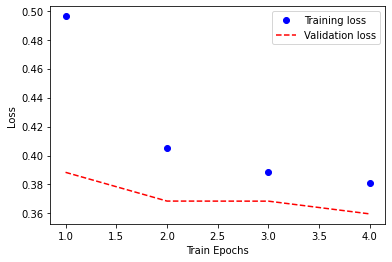

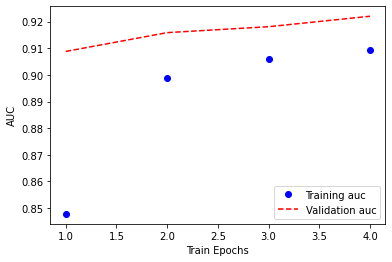

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["hla_linear_loss"]
val_loss = history_dict["val_hla_linear_loss"]
auc = history_dict["hla_linear_auc"]
val_auc = history_dict["val_hla_linear_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

#p = model.model(x_val[:1000,:])[0][:]
p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

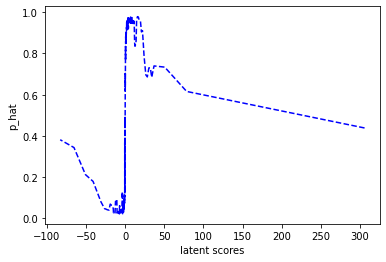

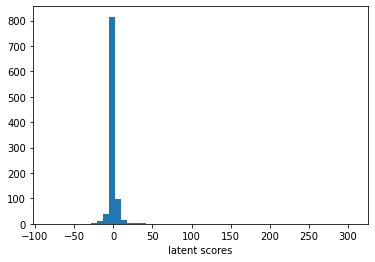

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

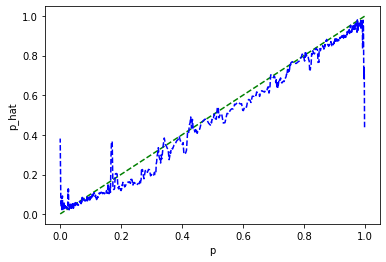

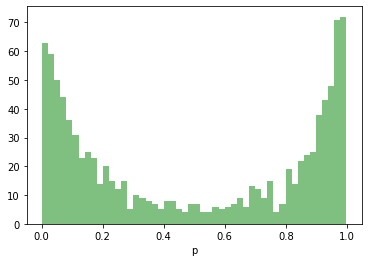

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

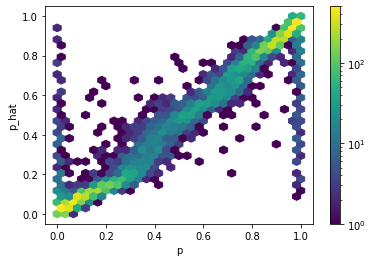

In [10]:
n = 1
s = 100

#p = model.model(x_val[:10000,:])[0][:].numpy()[:,0]
p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

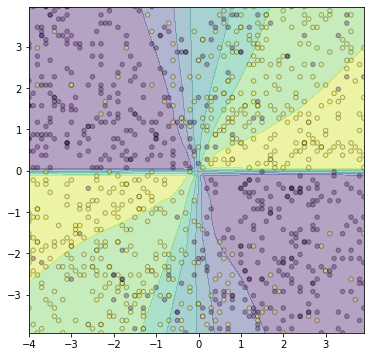

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z[:,0].reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "HLADropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10)]              0         
                                                                 
 dense_72 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_73 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_74 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0

In [13]:
champion_params

{'learning_rate': 0.007,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.3645873963832855, 'epoch': 4},
 'best_auc': {'auc': 0.9205309748649597, 'epoch': 6},
 'best_accuracy': {'accuracy': 0.8521000146865845, 'epoch': 6}}

In [13]:
## mcdropout 
##champion_params
{'learning_rate': 0.005600000000000001,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.35471731424331665, 'epoch': 6},
 'best_auc': {'auc': 0.9221413135528564, 'epoch': 6},
 'best_accuracy': {'accuracy': 0.8564000129699707, 'epoch': 6},
 'model': <keras.engine.sequential.Sequential at 0x7f01dc417220>}

{'learning_rate': 0.005600000000000001,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.21947233378887177, 'epoch': 6},
 'best_auc': {'auc': 0.9679520130157471, 'epoch': 6},
 'best_accuracy': {'accuracy': 0.9244999885559082, 'epoch': 6},
 'model': <keras.engine.sequential.Sequential at 0x7f3da9502970>}

In [22]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2992284297943115, 'epoch': 119},
  'best_auc': {'auc': 0.9505606293678284, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9125999808311462, 'epoch': 119}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2824668884277344, 'epoch': 119},
  'best_auc': {'auc': 0.9531910419464111, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9177500009536743, 'epoch': 119}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2683708965778351, 'epoch': 119},
  'best_auc': {'auc': 0.9568484425544739, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9197999835014343, 'epoch': 113}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.26549410820007324, 'epoch': 249},
  'best_auc': {'auc': 0.9579653739929199, 'epoch': 249},
  'b

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25